# Setup

In [1]:
n_cores = 12

## Imports

In [2]:
# isort: off
import os

num_threads = str(n_cores)

# these need to be set prior to numpy import
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

import numpy as np

# isort: on

import methlevels as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
import mouse_hema_meth.utils as ut
import pandas as pd
import seaborn as sns
from dendritic_cells.config import paper_context2
from IPython.display import Markdown, display
from pandas.api.types import CategoricalDtype

reloaded shared_vars
reloaded mhutils


## Paths

In [3]:
import dendritic_cells.analyses_for_manuscript_20201015_lib as lib

reloaded
reloaded styling


In [4]:
results_dir = "/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt"
os.makedirs(results_dir, exist_ok=True)

## Util functions

In [5]:
def link_fn(s, markdown=True):
    s = str(s)
    curry_path = s.replace(
        "/icgc/dkfzlsdf/analysis/hs_ontogeny/",
        "https://currywurst.dkfz.de/hs-ontogeny/",
    )
    if markdown:
        link = f'[{curry_path}]({curry_path} "will only work within the DKFZ network")'
        # noinspection PyTypeChecker
        display(Markdown(link))
    else:
        print(curry_path)

In [6]:
mpl.rcParams.update(paper_context2)

In [7]:
%matplotlib inline


## Recompute flag


In [8]:
recompute = False


# QC


## Flagstats

In [173]:
extended_flagstats_pattern = (
    "/icgc/dkfzlsdf/project/mouse_hematopoiesis/sequencing"
    "/whole_genome_bisulfite_tagmentation_sequencing/view-by-pid"
    "/{pop}_{rep}/blood/paired/merged-alignment/qualitycontrol/merged/flagstats"
    "/blood_{pop}_{rep}_merged.mdup.bam_extendedFlagstats.txt"
)
original_flagstats_pattern = (
    "/icgc/dkfzlsdf/project/mouse_hematopoiesis/sequencing"
    "/whole_genome_bisulfite_tagmentation_sequencing/view-by-pid"
    "/{pop}_{rep}/blood/paired/merged-alignment/qualitycontrol/merged/flagstats"
    "/blood_{pop}_{rep}_merged.mdup.bam_flagstats.txt"
)
file_pattern = original_flagstats_pattern

flagstats_df_full = lib.collect_original_flagstats(
    file_pattern=original_flagstats_pattern
)
display(flagstats_df_full.head())
flagstats_df_full.reset_index().to_csv(results_dir + "/flagstats-full.csv")
flagstats_df_full.to_pickle(results_dir + "/flagstats-full.p")
print(results_dir + "/flagstats-full.csv")
link_fn(results_dir + "/flagstats-full.csv")

Read QC status                               QC-passed reads  QC-failed reads
Population Replicate Stat                                                    
B cells    1         % Singletons                       0.00             0.00
                     % both mapped                      1.00             1.00
                     % diffchrom                        0.01             0.87
                     % diffchrom (mapQ >=5)             0.00             0.41
                     % duplicates                       0.18             0.02

/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/flagstats-full.csv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/flagstats-full.csv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/flagstats-full.csv "will only work within the DKFZ network")

In [174]:
flagstats_selected = (
    flagstats_df_full.loc[
        ["HSC", "MDP", "CDP", "cMoP", "Monocytes", "pDC", "cDC CD11b", "cDC CD8a"],
        "QC-passed reads",
    ]
    .unstack("Stat")
    .drop([("HSC", "1-1"), ("HSC", "4"), ("HSC", "5")], axis=0)
    .sort_index(ascending=False, axis=1)
)
display(flagstats_selected.head())
flagstats_selected.reset_index().to_csv(
    results_dir + "/flagstats-selected.csv", index=True
)
link_fn(results_dir + "/flagstats-selected.csv")
print(results_dir + "/flagstats-selected.csv")

Stat                      No. read2      No. read1       No. paired  \
Population Replicate                                                  
HSC        1         326,209,541.00 326,209,541.00   652,419,082.00   
           2         932,807,983.00 932,807,983.00 1,865,615,966.00   
           3         781,493,743.00 781,493,743.00 1,562,987,486.00   
MDP        1         619,365,672.00 619,365,672.00 1,238,731,344.00   
           2         590,804,745.00 590,804,745.00 1,181,609,490.00   

Stat                     No. of reads  No. of proper pairs  No. of duplicates  \
Population Replicate                                                            
HSC        1           652,419,082.00       640,739,362.00     216,129,000.00   
           2         1,865,615,966.00     1,826,429,452.00   1,160,867,926.00   
           3         1,562,987,486.00     1,501,035,900.00     767,432,513.00   
MDP        1         1,238,731,344.00     1,196,819,690.00     671,471,613.00   
           2         1,181,609,490.00     1,143,438,928.00     819,103,630.00   

Stat                  No. of Singletons       No. mapped  \
Population Replicate                                       
HSC        1                   4,540.00   651,955,166.00   
           2                  19,916.00 1,864,666,194.00   
           3                  46,427.00 1,561,822,505.00   
MDP        1                   8,139.00 1,238,161,001.00   
           2                   8,100.00 1,181,063,466.00   

Stat                  No. diffchrom (mapQ >=5)  No. diffchrom  ...  % read2  \
Population Replicate                                           ...            
HSC        1                      1,180,681.00   6,466,748.00  ...     0.50   
           2                      3,811,867.00  18,899,110.00  ...     0.50   
           3                      2,963,381.00  16,716,704.00  ...     0.50   
MDP        1                     11,139,172.00  29,793,034.00  ...     0.50   
           2                     10,384,727.00  27,315,686.00  ...     0.50   

Stat                  % read1  % proper pairs  % paired  % mapped  \
Population Replicate                                                
HSC        1             0.50            0.98      1.00      1.00   
           2             0.50            0.98      1.00      1.00   
           3             0.50            0.96      1.00      1.00   
MDP        1             0.50            0.97      1.00      1.00   
           2             0.50            0.97      1.00      1.00   

Stat                  % duplicates  % diffchrom (mapQ >=5)  % diffchrom  \
Population Replicate                                                      
HSC        1                  0.33                    0.00         0.01   
           2                  0.62                    0.00         0.01   
           3                  0.49                    0.00         0.01   
MDP        1                  0.54                    0.01         0.02   
           2                  0.69                    0.01         0.02   

Stat                  % both mapped  % Singletons  
Population Replicate                               
HSC        1                   1.00          0.00  
           2                   1.00          0.00  
           3                   1.00          0.00  
MDP        1                   1.00          0.00  
           2                   1.00          0.00  

[5 rows x 22 columns]

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/flagstats-selected.csv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/flagstats-selected.csv "will only work within the DKFZ network")

/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/flagstats-selected.csv



## Metadata table

In [38]:
from mouse_hema_meth.methylome.alignments_mcalls.meth_calling_paths import (
    ds1_metadata_table_tsv,
)

# compared to ds1, we
#  - restrict to the pops used in the papr
#  - drop one HSC replicate
#  - use monos-new instead of monos

pops = ["cdp", "cmop", "dc-cd11b", "dc-cd8a", "hsc", "mdp", "monos", "pdc"]
mcalls_metadata_table = (
    pd.read_csv(ds1_metadata_table_tsv, sep="\t")
    .set_index(["subject", "rep"])
    .loc[pops]
    .drop(("hsc", 4), axis=0)
)

mcalls_metadata_table.loc["monos", "bed_path"] = (
    mcalls_metadata_table.loc["monos", "bed_path"]
    .str.replace("monos", "monos-new")
    .to_numpy()
)
mcalls_metadata_table.loc["monos", "pickle_path"] = (
    mcalls_metadata_table.loc["monos", "pickle_path"]
    .str.replace("monos", "monos-new")
    .to_numpy()
)


## Conversion rates


In [23]:
chh_meth = lib.gather_conversion_rate_table(mcalls_metadata_table)
display(chh_meth.head())
chh_meth.to_csv(results_dir + "/conversion-rates.csv")
print(results_dir + "/conversion-rates.csv")
link_fn(results_dir + "/conversion-rates.csv")

,Population,Replicate,Chromosome,Motif,N methylated,N unmethylated,Beta value,% Methylation,Est. conversion rate
1,CDP,1,1,CH,3640414,291976732,0.01,1.23,98.77
5,CDP,2,1,CH,4040354,615671258,0.01,0.65,99.35
9,CDP,3,1,CH,3487881,527659339,0.01,0.66,99.34
13,CDP,4,1,CH,2962260,341178736,0.01,0.86,99.14
49,HSC,1,1,CH,1877738,366559667,0.01,0.51,99.49


/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/conversion-rates.csv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/conversion-rates.csv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/conversion-rates.csv "will only work within the DKFZ network")


## Coverage


In [18]:
# computed in hema meth project
pops = ["cdp", "cmop", "dc-cd11b", "dc-cd8a", "hsc", "mdp", "monos", "pdc"]
pop_coverage_p = "/icgc/dkfzlsdf/analysis/hs_ontogeny/results/wgbs/cohort_results/analyses/hierarchy/mcalling/qc/coverage/n-total_pop-level.p"
pop_ntotal = pd.read_pickle(pop_coverage_p)[pops]
pop_ntotal

,cdp,cmop,dc-cd11b,dc-cd8a,hsc,mdp,monos,pdc
0,33,16,28,31,47,21,44,42
1,38,10,29,42,48,19,38,41
2,34,8,24,42,42,18,42,39
3,24,5,15,30,41,9,26,29
4,23,12,17,17,35,17,36,35
...,...,...,...,...,...,...,...,...
20383618,43,18,19,23,23,15,32,27
20383619,54,17,24,26,31,20,28,35
20383620,46,22,19,37,38,15,35,28
20383621,53,22,27,37,31,21,34,31


Restrict coverage to the three already published HSC replicates

In [19]:
n_total = pd.Series(0, index=pop_ntotal.index, dtype="i8")
for fp in mcalls_metadata_table.loc["hsc", "pickle_path"].tolist():
    n_total += pd.read_pickle(fp)["n_total"]
pop_ntotal["hsc"] = n_total

Update monos to use the old monos

In [23]:
n_total = pd.Series(0, index=pop_ntotal.index, dtype="i8")
for fp in mcalls_metadata_table.loc["monos", "bed_path"].tolist():
    print(fp)
    n_total += pd.read_csv(fp, sep="\t")["n_total"]
    print(n_total.mean())
pop_ntotal["monos"] = n_total

/icgc/dkfzlsdf/analysis/hs_ontogeny/results/wgbs/results_per_pid/v1_bistro-0.2.0_odcf-alignment/monos-new_1/meth/meth_calls/mcalls_monos-new_1_CG_chrom-merged_strands-merged.bed.gz
1.5140698491136733
/icgc/dkfzlsdf/analysis/hs_ontogeny/results/wgbs/results_per_pid/v1_bistro-0.2.0_odcf-alignment/monos-new_2/meth/meth_calls/mcalls_monos-new_2_CG_chrom-merged_strands-merged.bed.gz
4.256200970749901
/icgc/dkfzlsdf/analysis/hs_ontogeny/results/wgbs/results_per_pid/v1_bistro-0.2.0_odcf-alignment/monos-new_3/meth/meth_calls/mcalls_monos-new_3_CG_chrom-merged_strands-merged.bed.gz
6.602389035550746


In [24]:
coverage_mean_sd = pop_ntotal.describe().T
coverage_mean_sd

,count,mean,std,min,25%,50%,75%,max
cdp,"20,383,623.00",44.28,29.13,0.00,33.00,44.00,56.00,"8,438.00"
cmop,"20,383,623.00",18.72,13.35,0.00,13.00,18.00,24.00,"4,111.00"
dc-cd11b,"20,383,623.00",21.77,14.68,0.00,16.00,22.00,28.00,"6,686.00"
dc-cd8a,"20,383,623.00",31.28,19.28,0.00,25.00,32.00,39.00,"7,536.00"
hsc,"20,383,623.00",32.64,20.33,0.00,27.00,34.00,40.00,"7,084.00"
mdp,"20,383,623.00",23.00,16.11,0.00,17.00,23.00,29.00,"4,884.00"
monos,"20,383,623.00",6.60,7.47,0.00,4.00,6.00,9.00,"5,547.00"
pdc,"20,383,623.00",32.53,19.99,0.00,25.00,33.00,41.00,"7,373.00"


In [28]:
coverage_mean_sd.index.name = "Population"
coverage_mean_sd_tsv = results_dir + "/coverage-mean-sd2.csv"
coverage_mean_sd.reset_index().to_csv(coverage_mean_sd_tsv, sep="\t")
print(coverage_mean_sd_tsv)
link_fn(coverage_mean_sd_tsv)

/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/coverage-mean-sd2.csv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/coverage-mean-sd2.csv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/coverage-mean-sd2.csv "will only work within the DKFZ network")


## Average methylation


In [359]:
(
    pop_quantiles_df,
    pop_quantiles_df_long,
    sampled_rep_meth_df,
    sampled_pop_meth_df,
    beta_value_pop_df,
    pop_beta_value_mean_df,
    rep_beta_value_mean_df,
) = lib.gather_meth_level_data(
    mcalls_metadata_table=mcalls_metadata_table.reset_index(),
    recompute=recompute,
    pop_quantiles_wide_p=results_dir + "/pop_beta-value_quantiles_wide.p",
    pop_quantiles_long_p=results_dir + "/pop_beta-value_quantiles_long.p",
    sampled_rep_betavalue_p=results_dir + "/pop_beta-value_sampled_rep.p",
    sampled_pop_betavalue_p=results_dir + "/pop_beta-value_sampled_pop.p",
    pop_betavalue_p=results_dir + "/pop_beta-values_all-cpgs.p",
    pop_betavalue_mean_df_p=results_dir + "/pop_beta-values_mean-sd.p",
    rep_beta_value_mean_p=results_dir + "/rep_beta-values_mean-sd.p",
)

cdp
cmop
dc-cd11b
dc-cd8a
hsc
mdp
monos
pdc


In [360]:
rep_beta_value_mean_df_long = (
    rep_beta_value_mean_df.unstack()
    .rename_axis(["Population", "Replicate"], axis=0)
    .reset_index()
)
rep_beta_value_mean_df_long

,Population,Replicate,mean,std,var,median
0,cdp,1,0.83,0.30,0.09,1.00
1,cdp,2,0.85,0.29,0.08,0.92
2,cdp,3,0.84,0.29,0.08,0.92
3,cdp,4,0.84,0.29,0.09,0.92
4,cmop,1,0.83,0.29,0.08,0.90
5,cmop,2,0.83,0.29,0.08,0.92
6,dc-cd11b,1,0.83,0.29,0.08,0.91
7,dc-cd11b,2,0.80,0.32,0.10,1.00
8,dc-cd11b,3,0.82,0.30,0.09,0.90
9,dc-cd8a,1,0.83,0.29,0.08,0.91


In [361]:
rep_beta_value_mean_df_long.to_csv(results_dir + "/rep-beta-values_mean-sd.csv")
link_fn(results_dir + "/rep-beta-values_mean-sd.csv")

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/rep-beta-values_mean-sd.csv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/rep-beta-values_mean-sd.csv "will only work within the DKFZ network")


# Retrieve and format input data


## Read from RDS


Get cluster ids and dmr boundaries to TSV format, load into python, adjust column names and convert Chromosome to string categorical

In [9]:
dmr_calls_dir = (
    "/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-calls"
)
dmr_calls_dir

'/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-calls'

In [10]:
cluster_ids_rds = results_dir + "/nW05rWZyjo0wFEVK.rds"
cluster_ids_tsv = results_dir + "/nW05rWZyjo0wFEVK.tsv"
cluster_ids_rds

'/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/nW05rWZyjo0wFEVK.rds'

In [11]:
cluster_ids_beta_values_dmr_coords = pd.read_csv(cluster_ids_tsv, sep="\t")


## Note: some values are NA


In [12]:
cluster_ids_beta_values_dmr_coords[
    [
        "hsc",
        "cdp",
        "cmop",
        "dc_cd11b",
        "dc_cd8a",
        "mono",
        "mdp",
        "pdc",
    ]
].isnull().sum()

hsc          0
cdp          0
cmop         0
dc_cd11b     0
dc_cd8a      0
mono        12
mdp          1
pdc          0
dtype: int64

### Bring Granges into standard format, add region_id

In [13]:
chrom_dtype = CategoricalDtype(
    np.sort(np.arange(1, 20).astype(str)),
    ordered=True,
)
chrom_dtype

CategoricalDtype(categories=['1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                  '19', '2', '3', '4', '5', '6', '7', '8', '9'],
                 ordered=True)

In [14]:
cluster_ids_beta_values_dmr_coords["chr"] = (
    cluster_ids_beta_values_dmr_coords["chr"].astype(str).astype(chrom_dtype)
)

In [15]:
cluster_ids_beta_values_dmr_coords = (
    cluster_ids_beta_values_dmr_coords.rename(
        columns={"chr": "Chromosome", "start": "Start", "end": "End"}
    )
    .sort_values(["Chromosome", "Start", "End"])
    .reset_index(drop=True)
    .rename_axis(index="region_id")
)

In [16]:
cluster_ids_beta_values_dmr_coords

,Chromosome,Start,End,hsc,cdp,cmop,dc_cd11b,dc_cd8a,mono,mdp,pdc,cluster
region_id,,,,,,,,,,,,
0,1,4617581,4617808,0.32,0.89,0.88,0.81,0.91,0.91,0.90,0.92,9
1,1,4623081,4623184,0.03,0.59,0.60,0.55,0.54,0.59,0.63,0.54,9
2,1,5076336,5076640,0.77,0.34,0.35,0.31,0.22,0.40,0.31,0.10,5
3,1,6263050,6263210,0.90,0.82,0.79,0.62,0.53,0.83,0.85,0.35,3
4,1,6454102,6454429,0.71,0.25,0.21,0.27,0.38,0.40,0.32,0.31,4
...,...,...,...,...,...,...,...,...,...,...,...,...
49596,9,124090237,124091149,0.89,0.77,0.72,0.49,0.33,0.43,0.90,0.74,1
49597,9,124101863,124104273,0.89,0.35,0.19,0.46,0.37,0.16,0.32,0.66,4
49598,9,124121334,124122358,0.71,0.25,0.25,0.13,0.14,0.37,0.39,0.18,2



## Extract individual dataframes (cluster ids, dmrs, betas)


### DMRs


In [17]:
dmrs = cluster_ids_beta_values_dmr_coords[["Chromosome", "Start", "End"]]
dmrs

,Chromosome,Start,End
region_id,,,
0,1,4617581,4617808
1,1,4623081,4623184
2,1,5076336,5076640
3,1,6263050,6263210
4,1,6454102,6454429
...,...,...,...
49596,9,124090237,124091149
49597,9,124101863,124104273
49598,9,124121334,124122358



### Cluster ids


In [18]:
cluster_ids_df = cluster_ids_beta_values_dmr_coords[["cluster"]]
cluster_ids_df

,cluster
region_id,
0,9
1,9
2,5
3,3
4,4
...,...
49596,1
49597,4
49598,2



### Betas


In [19]:
beta_values = cluster_ids_beta_values_dmr_coords[
    [
        "hsc",
        "mdp",
        "cdp",
        "cmop",
        "mono",
        "pdc",
        "dc_cd11b",
        "dc_cd8a",
    ]
].dropna(how="any", axis=0)
zscores = ut.row_zscores(beta_values)
cluster_ids_no_nas = cluster_ids_df.loc[beta_values.index].copy()

In [21]:
beta_values.describe().reset_index().to_csv(
    results_dir + "/dmr-beta-value_agg-stats.tsv"
)
ut.dkfz_link(results_dir + "/dmr-beta-value_agg-stats.tsv")

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-beta-value_agg-stats.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-beta-value_agg-stats.tsv "will only work within the DKFZ network")


## Extract Rep methlevels

if recompute:
    meth_stats_rep = lib.get_rep_meth_levels(mcalls_metadata_table, dmrs, n_cores)
    ut.to_pickle(meth_stats_rep, results_dir + '/rep-level-methstats_obj.p')
else:
    meth_stats_rep = ut.from_pickle(results_dir + '/rep-level-methstats_obj.p')


# Meth levels in DMRs


In [20]:
beta_values

,hsc,mdp,cdp,cmop,mono,pdc,dc_cd11b,dc_cd8a
region_id,,,,,,,,
0,0.32,0.90,0.89,0.88,0.91,0.92,0.81,0.91
1,0.03,0.63,0.59,0.60,0.59,0.54,0.55,0.54
2,0.77,0.31,0.34,0.35,0.40,0.10,0.31,0.22
3,0.90,0.85,0.82,0.79,0.83,0.35,0.62,0.53
4,0.71,0.32,0.25,0.21,0.40,0.31,0.27,0.38
...,...,...,...,...,...,...,...,...
49596,0.89,0.90,0.77,0.72,0.43,0.74,0.49,0.33
49597,0.89,0.32,0.35,0.19,0.16,0.66,0.46,0.37
49598,0.71,0.39,0.25,0.25,0.37,0.18,0.13,0.14


## Aggregated distribution stats

### Rep-level


### Pop-level


beta values are already filtered for complete observations

In [23]:
assert not beta_values.isnull().any().any()

In [36]:
q1_median_q3_pop_wide = (
    beta_values.describe()
    .T.reset_index()
    .rename(columns={"index": "pop", "25%": "Q1", "50%": "median", "75%": "Q3"})
)
q1_median_q3_pop_wide

,pop,count,mean,std,min,Q1,median,Q3,max
0,hsc,"49,588.00",0.81,0.20,0.00,0.76,0.87,0.93,1.00
1,mdp,"49,588.00",0.59,0.26,0.00,0.39,0.62,0.82,1.00
2,cdp,"49,588.00",0.55,0.26,0.00,0.35,0.57,0.78,0.99
3,cmop,"49,588.00",0.48,0.28,0.00,0.23,0.46,0.73,1.00
4,mono,"49,588.00",0.41,0.30,0.00,0.14,0.36,0.66,1.00
5,pdc,"49,588.00",0.50,0.28,0.00,0.25,0.49,0.75,1.00
6,dc_cd11b,"49,588.00",0.42,0.26,0.00,0.20,0.39,0.64,1.00
7,dc_cd8a,"49,588.00",0.37,0.24,0.00,0.18,0.31,0.53,1.00


In [34]:
q1_median_q3_pop_long = (
    beta_values.describe()
    .T.reset_index()
    .rename(columns={"index": "pop", "25%": "Q1", "50%": "median", "75%": "Q3"})[
        ["pop", "Q1", "median", "Q3"]
    ]
    .set_index("pop")
    .stack()
    .to_frame()
    .reset_index()
    .set_axis(["pop", "stat", "value"], axis=1)
)
q1_median_q3_rep

,pop,stat,value
0,hsc,Q1,0.76
1,hsc,median,0.87
2,hsc,Q3,0.93
3,mdp,Q1,0.39
4,mdp,median,0.62
5,mdp,Q3,0.82
6,cdp,Q1,0.35
7,cdp,median,0.57
8,cdp,Q3,0.78
9,cmop,Q1,0.23



## Population distribution plots


### Violin all


In [33]:
fig, ax = plt.subplots(
    1, 1, figsize=(ut.cm(8), ut.cm(5)), constrained_layout=True, dpi=180
)
sns.violinplot(data=beta_values.sample(1000), cut=0, inner="box", width=0.9)
ax.set_ylabel("DMR methylation")
ut.save_and_display(fig, png_path=results_dir + "/global-dmr-beta-values_violin.png")


### Violin selected


In [32]:
fig, ax = plt.subplots(
    1, 1, figsize=(ut.cm(3), ut.cm(5)), constrained_layout=True, dpi=180
)
sns.violinplot(
    data=beta_values[["pdc", "dc_cd11b", "dc_cd8a"]].sample(1000),
    cut=0,
    inner="box",
    width=0.9,
)
ax.set_ylabel("DMR methylation")
ut.save_and_display(
    fig, png_path=results_dir + "/global-dmr-beta-values_violin_dcs-only.png"
)


### Boxplot all


In [36]:
fig, ax = plt.subplots(
    1, 1, figsize=(ut.cm(8), ut.cm(8)), constrained_layout=True, dpi=180
)
sns.boxplot(data=beta_values.sample(1000), showfliers=False)
ut.save_and_display(fig, png_path=results_dir + "/global-dmr-beta-values_boxplot.png")


# Characterize clustering


In [80]:
beta_values.isnull().sum()

hsc         0
mdp         0
cdp         0
cmop        0
mono        0
pdc         0
dc_cd11b    0
dc_cd8a     0
dtype: int64


## Heatmap


In [81]:
import clustering_tools as ct
import mouse_hema_meth.utils as ut

In [82]:
global_row_order_df = ct.hclust_within_clusters(
    data=zscores,
    cluster_ids_df=cluster_ids_no_nas,
    metric="euclidean",
    method="ward",
    n_jobs=9,
)

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/heatmap_zscores_hclust-within-clusters.png](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/heatmap_zscores_hclust-within-clusters.png "will only work within the DKFZ network")

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/heatmap_zscores_hclust-within-clusters.pdf](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/heatmap_zscores_hclust-within-clusters.pdf "will only work within the DKFZ network")

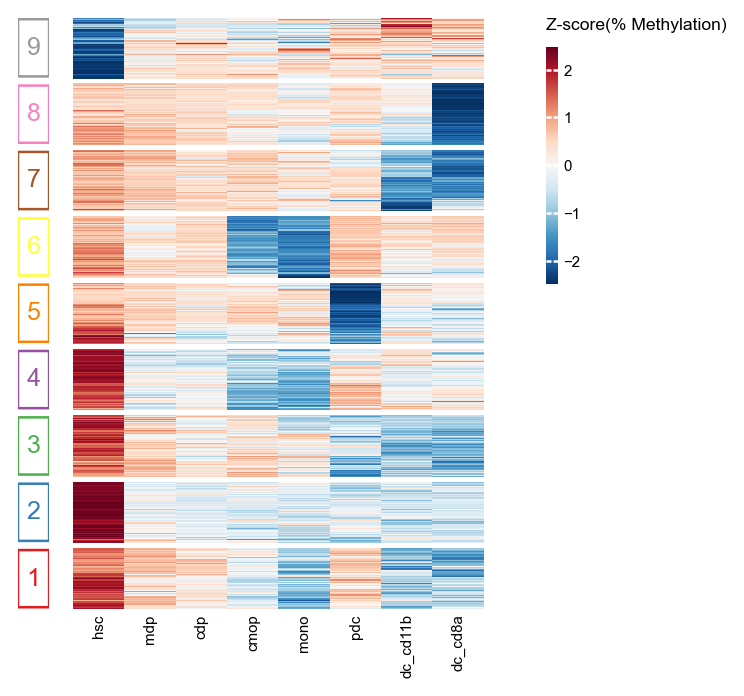

In [83]:
png_path = results_dir + "/heatmap_zscores_hclust-within-clusters.png"
lib.create_clustermaps_with_special_order(
    df=zscores,
    cluster_ids_df=cluster_ids_no_nas,
    png_path=png_path,
    cmap="RdBu_r",
    guide_title="Z-score(% Methylation)",
    global_row_order_df=global_row_order_df,
    figsize=(10 / 2.54, 10 / 2.54),
    n_per_cluster=500,
)
link_fn(png_path)
link_fn(png_path.replace(".png", ".pdf"))

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/heatmap_beta-values_hclust-within-clusters.png](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/heatmap_beta-values_hclust-within-clusters.png "will only work within the DKFZ network")

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/heatmap_beta-values_hclust-within-clusters.pdf](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/heatmap_beta-values_hclust-within-clusters.pdf "will only work within the DKFZ network")

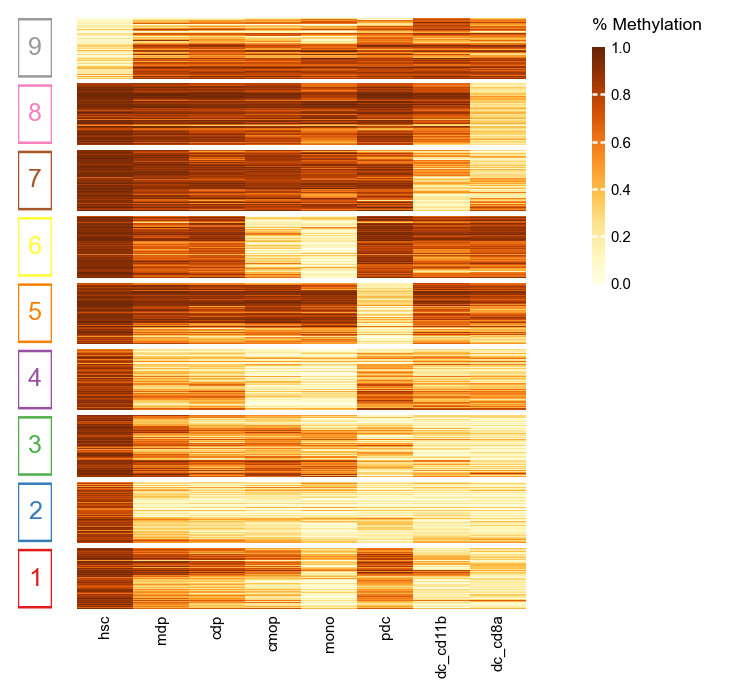

In [84]:
png_path = results_dir + "/heatmap_beta-values_hclust-within-clusters.png"
lib.create_clustermaps_with_special_order(
    df=beta_values,
    cluster_ids_df=cluster_ids_no_nas,
    png_path=png_path,
    cmap="YlOrBr",
    guide_title="% Methylation",
    global_row_order_df=global_row_order_df,
    figsize=(10 / 2.54, 10 / 2.54),
    n_per_cluster=500,
)
link_fn(png_path)
link_fn(png_path.replace(".png", ".pdf"))


## Cluster sizes


1    7927
2    7426
3    7170
4    6247
5    5003
6    4428
7    4102
8    3912
9    3373
Name: cluster, dtype: int64

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/cluster-sizes.pdf](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/cluster-sizes.pdf "will only work within the DKFZ network")

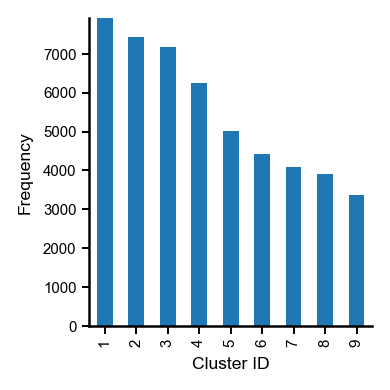

In [85]:
fig, ax = plt.subplots(
    1, 1, constrained_layout=True, dpi=180, figsize=(5 / 2.54, 5 / 2.54)
)
cluster_sizes = cluster_ids_df["cluster"].value_counts()
display(cluster_sizes)
cluster_sizes.plot.bar(ax=ax)
ax.set(ylabel="Frequency", xlabel="Cluster ID")
fig.savefig(results_dir + "/cluster-sizes.pdf")
link_fn(results_dir + "/cluster-sizes.pdf")


## Gain/loss stratified counts


not all dmrs have only one sign (deltas < 0.1 are not considered here)

In [27]:
masked_signs = np.sign(
    beta_values.subtract(beta_values["hsc"], axis=0).mask(lambda df: df.abs().le(0.1))
)

In [30]:
masked_signs.nunique(axis=1).ne(1).sum()

369

we can use the max delta

In [32]:
max_delta_for_each_dmr = beta_values.subtract(beta_values["hsc"], axis=0).apply(
    lambda ser: ser.loc[ser.abs().idxmax()], axis=1
)
max_delta_for_each_dmr

region_id
0        0.60
1        0.60
2       -0.67
3       -0.54
4       -0.50
         ... 
49596   -0.56
49597   -0.73
49598   -0.58
49599    0.58
49600   -0.60
Length: 49588, dtype: float64

In [34]:
gain_loss_classif = np.sign(max_delta_for_each_dmr).replace({1: "Gain", -1: "Loss"})
gain_loss_classif

region_id
0        Gain
1        Gain
2        Loss
3        Loss
4        Loss
         ... 
49596    Loss
49597    Loss
49598    Loss
49599    Gain
49600    Loss
Length: 49588, dtype: object

In [36]:
gain_loss_classif.value_counts()

Loss    46215
Gain     3373
dtype: int64


# Gene annotation


## Computation


In [16]:
gtf_fp = (
    "/icgc/dkfzlsdf/analysis/hs_ontogeny/databases/gene_annotations"
    "/gencode.vM19.annotation.no-prefix.gtf"
)

In [17]:
anno_res_paths_d = lib.run_gtfanno(
    granges_df=dmrs,
    gtf_fp=gtf_fp,
    output_trunk_path=results_dir + "/dmr-gene-annos",
    promoter_def=(-5000, 1000),
    distant_cis_regulatory_domain_def=(-50000, -5000),
    recompute=False,
)


## Paths to detailed annotations


In [18]:
anno_res_paths_d

{'primary_annos_bed': '/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.bed',
 'primary_annos_p': '/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.p',
 'all_annos_bed': '/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.bed',
 'all_annos_p': '/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.p'}

In [19]:
for k, v in anno_res_paths_d.items():
    print(k)
    link_fn(v)

primary_annos_bed


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.bed](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.bed "will only work within the DKFZ network")

primary_annos_p


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.p](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.p "will only work within the DKFZ network")

all_annos_bed


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.bed](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.bed "will only work within the DKFZ network")

all_annos_p


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.p](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.p "will only work within the DKFZ network")


## Paths to merged annotations


One row per DMR, one feature class per DMR (one of promoter, exon, etc.)

In [20]:
if recompute:
    merged_annos = lib.merge_annos(
        gtfanno_result_fp=anno_res_paths_d["primary_annos_p"],
        grange_and_feature_ids=dmrs,
    )
    merged_annos.to_pickle(results_dir + "/merged-gene-annos.p")
    merged_annos.to_csv(results_dir + "/merged-gene-annos.tsv", sep="\t", index=False)
else:
    merged_annos = pd.read_pickle(results_dir + "/merged-gene-annos.p")

In [21]:
merged_annos

,Chromosome,Start,End,gene_name,feat_class
region_id,,,,,
0,1,4617581,4617808,Gm37323,DCRD
1,1,4623081,4623184,Gm37323,DCRD
2,1,5076336,5076640,Atp6v1h,intron
3,1,6263050,6263210,Rb1cc1,Promoter
4,1,6454102,6454429,"St18,Gm19026",DCRD
...,...,...,...,...,...
49596,9,124090237,124091149,"Ccr5,Ccr2",DCRD
49597,9,124101863,124104273,Ccr2,Promoter
49598,9,124121334,124122358,Ccr5,Promoter


In [22]:
print(results_dir + "/merged-gene-annos.p")
print(results_dir + "/merged-gene-annos.tsv")
link_fn(results_dir + "/merged-gene-annos.tsv")

/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/merged-gene-annos.p
/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/merged-gene-annos.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/merged-gene-annos.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/merged-gene-annos.tsv "will only work within the DKFZ network")


## Genomic regions quick viz


note about UTRs: i double checked the UTR calling; and I have set 5'-UTR precedence higher than promoters, so this is not an effect of covering 5'-UTRs with promoters. The picture is very similar to global hematopoiesis in general.

<AxesSubplot:>

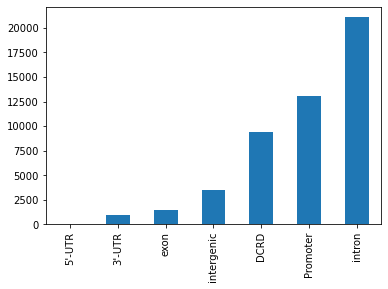

In [23]:
merged_annos["feat_class"].value_counts().sort_values().plot.bar()


# Concatenate all available annotations


In [38]:
all_annos = pd.concat(
    [cluster_ids_beta_values_dmr_coords, merged_annos[["gene_name", "feat_class"]]],
    axis=1,
)[
    [
        "Chromosome",
        "Start",
        "End",
        "cluster",
        "gene_name",
        "feat_class",
        "hsc",
        "cdp",
        "cmop",
        "dc_cd11b",
        "dc_cd8a",
        "mono",
        "mdp",
        "pdc",
    ]
]
all_annos_tsv = results_dir + "/all-annos.tsv"
all_annos.to_csv(all_annos_tsv, sep="\t", index=False, header=True)
all_annos.to_parquet(all_annos_tsv.replace(".tsv", ".parquet"))
all_annos.head()

,Chromosome,Start,End,cluster,gene_name,feat_class,hsc,cdp,cmop,dc_cd11b,dc_cd8a,mono,mdp,pdc
region_id,,,,,,,,,,,,,,
0,1,4617581,4617808,9,Gm37323,DCRD,0.32,0.89,0.88,0.81,0.91,0.91,0.90,0.92
1,1,4623081,4623184,9,Gm37323,DCRD,0.03,0.59,0.60,0.55,0.54,0.59,0.63,0.54
2,1,5076336,5076640,5,Atp6v1h,intron,0.77,0.34,0.35,0.31,0.22,0.40,0.31,0.10
3,1,6263050,6263210,3,Rb1cc1,Promoter,0.90,0.82,0.79,0.62,0.53,0.83,0.85,0.35
4,1,6454102,6454429,4,"St18,Gm19026",DCRD,0.71,0.25,0.21,0.27,0.38,0.40,0.32,0.31


In [41]:
print(all_annos_tsv)
link_fn(all_annos_tsv)

/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/all-annos.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/all-annos.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/all-annos.tsv "will only work within the DKFZ network")


## Promoter DMR annos only


In [39]:
promoter_genes = all_annos.query('feat_class == "Promoter"').sort_values(
    ["cluster", "gene_name"]
)
promoter_genes_tsv = results_dir + "/promoter_genes.tsv"
promoter_genes.to_csv(promoter_genes_tsv, sep="\t", index=False, header=True)
promoter_genes.to_parquet(promoter_genes_tsv.replace(".tsv", ".parquet"))
promoter_genes.head()

,Chromosome,Start,End,cluster,gene_name,feat_class,hsc,cdp,cmop,dc_cd11b,dc_cd8a,mono,mdp,pdc
region_id,,,,,,,,,,,,,,
40660,6,108664906,108665088,1,0610040F04Rik,Promoter,0.94,0.61,0.36,0.17,0.40,0.23,0.56,0.67
36359,5,63813357,63813554,1,0610040J01Rik,Promoter,0.74,0.43,0.47,0.05,0.06,0.22,0.59,0.32
39563,6,48925755,48926079,1,1600015I10Rik,Promoter,0.92,0.55,0.37,0.29,0.50,0.45,0.53,0.78
21905,17,47441394,47441483,1,1700001C19Rik,Promoter,0.78,0.29,0.12,0.26,0.15,0.02,0.31,0.54
8798,11,98361684,98361975,1,1700003D09Rik,Promoter,0.89,0.59,0.50,0.13,0.30,0.40,0.68,0.49


In [40]:
print(promoter_genes_tsv)
link_fn(promoter_genes_tsv)

/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/promoter_genes.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/promoter_genes.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/promoter_genes.tsv "will only work within the DKFZ network")


# Geneset enrichment


## Geneset inspection (readme!)


**Note1**

There are duplicates within the genesets; beware of this in other analyses too!

**Note2**

The cardinality of the genesets is in part quite high; it may be beneficial for the analysis or the interpretation of the analysis if this is repeated with more curated genelists. Such as it is, each cluster has a high number of gene overlaps, which may be more difficult to interprete. (See section at the end of the notebook)

**Note3**

A considerable number of genes occurs in multiple clusters; is this intended?

In [23]:
dc_genesets_csv = (
    "/home/kraemers/projects/dendritic_cells/local/genesets/concat_genesets.csv"
)

In [24]:
rosenbauer_genesets_df = pd.read_csv(dc_genesets_csv, sep="\t", header=0)


### Geneset contains duplicates (link to cleaned genesets at the end)


The genelists contain multiple mentions of the same genes, this has to be corrected and should be relayed back to the Rosenbauer lab, since this could also affect other analyses, if these genelists would be used elsewherejf.
Number of mentions of unique genes per main geneset (eg 20 genes in coeff4_down are mentioned twice)

In [25]:
rosenbauer_genesets_df.apply(
    lambda ser: ser.dropna().str.upper().value_counts().value_counts(), axis=0
)

,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,672.00,740.00,592.00,871.00,463.00,742,115.00,177.00,71.00,15.00,...,40.00,67.00,78.00,13.00,7.00,45.00,54.00,108.00,38.00,104.00
2,20.00,7.00,19.00,22.00,7.00,19,2.00,2.00,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,1.00,2.00,nan,4.00,1.00,2,1.00,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,1.00,1.00,nan,1,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,2.00,nan,1.00,nan,nan,1,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


coeff4_down detailed

In [26]:
with pd.option_context("display.min_rows", 200):
    # pd.options.display.max_rows=200
    display(
        rosenbauer_genesets_df["coeff4_down"]
        .value_counts()
        .to_frame("frequency")
        .query("frequency > 1")
    )

,frequency
Scd2,6
mmu-mir-466b-1,6
mmu-mir-466c-1,3
Bgn,2
Twsg1,2
Ltf,2
Dusp6,2
Hba-a1,2
Cxcr2,2
Alox5,2


remove duplicates

In [27]:
rosenbauer_genesets_no_duplicates = rosenbauer_genesets_df.mask(
    rosenbauer_genesets_df.apply(
        lambda ser: ser.str.upper().duplicated(keep="first"), axis=0
    )
)

verify

In [28]:
rosenbauer_genesets_no_duplicates.apply(
    lambda ser: ser.dropna().str.upper().value_counts().value_counts(), axis=0
)

,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,695,749,613,898,471,765,118,179,71,15,...,40,67,78,13,7,45,54,108,38,104


In [29]:
rosenbauer_genesets_no_duplicates

,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
0,Car1,Phf12,Dntt,Atg3,Dntt,Trappc10,Klk8,Kif9,Wdr6,Vcam1,...,Mmp9,Gys1,Pafah1b3,Vcam1,Sdc1,Scarb1,Scd2,Nmt1,Satb1,Glrx
1,Cpa3,Gatm,Car1,Srd5a3,Il7r,Prtn3,Bex4,Olfr1009,Ly6a,Irf8,...,Ier5,Rps6ka2,Dpp4,Pld3,Plxnb2,Ctsc,Casp6,Anxa6,Mov10,Gys1
2,Pf4,Commd8,Ahsp,Sf3b5,Hist1h3d,Eif3g,Ncam1,3110057O12Rik,Ccnd1,Slc39a8,...,Egln3,Rsph1,Fyn,Laptm4b,Camk2d,Gstm1,Tmem109,Suclg1,Ulk1,Klc4
3,Ahsp,n-R5s159,Tspan13,Atp6v1b2,Cmah,Fgd6,Ctsf,Phyhd1,Tgm2,Itpr3,...,Ngp,Hnmt,Slc15a2,Hebp1,Olfm1,Smpdl3a,Rps15,Gm2a,Phf1,Tuba4a
4,Car2,Fuca2,Prg2,LOC101055658,Igh-VJ558,Mapk3,Hspa1a,Lgalsl,Fyn,Icosl,...,Prok2,Pygl,Rgs1,Pdia5,Fam129b,Soat1,Sepw1,Vac14,Ier5,Grina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,NaN,NaN,NaN,Far2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
927,NaN,NaN,NaN,Trem3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
928,NaN,NaN,NaN,Sgms2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929,NaN,NaN,NaN,1810033B17Rik,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
rosenbauer_genesets_no_duplicates_tsv = (
    results_dir + "/rosenbauer-genesets_no-duplicates.tsv"
)
rosenbauer_genesets_no_duplicates.to_csv(
    rosenbauer_genesets_no_duplicates_tsv, sep="\t"
)

In [31]:
print(rosenbauer_genesets_no_duplicates_tsv)
link_fn(rosenbauer_genesets_no_duplicates_tsv)

/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/rosenbauer-genesets_no-duplicates.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/rosenbauer-genesets_no-duplicates.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/rosenbauer-genesets_no-duplicates.tsv "will only work within the DKFZ network")


### Genesets are large


Number of unique genes

In [32]:
rosenbauer_genesets_no_duplicates.stack().nunique()

2939

<AxesSubplot:>

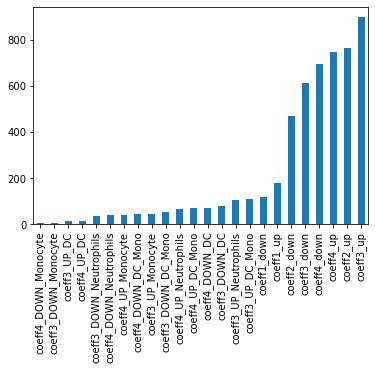

In [33]:
rosenbauer_genesets_no_duplicates.notnull().sum().sort_values().plot.bar()


### Genes occur in multiple clusters


Example: just the non cell type specific clusters

In [34]:
n_cluster_per_gene = (
    rosenbauer_genesets_no_duplicates
    # filter for non cell type specific genesets
    .filter(regex=r"(down|up)$")
    .stack()
    .value_counts()
    .sort_values(ascending=False)
)

Histogram of #clusters per gene

<AxesSubplot:>

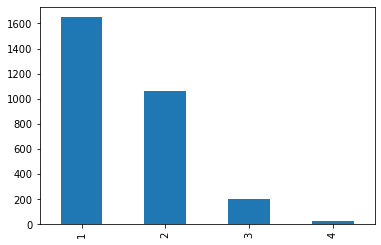

In [35]:
n_cluster_per_gene.value_counts().plot.bar()

In [36]:
with pd.option_context("display.min_rows", 50, "display.max_rows", 50):
    display(n_cluster_per_gene.head(30))

Siglecg          4
Gstm4            4
Emp1             4
Fcgr3            4
Epb4.1l4b        4
Fnbp1l           4
Rps6ka2          4
Mc5r             4
Myadml2          4
Mira             4
Swsap1           4
H2-Q9            4
n-R5s40          4
Bmx              4
Retsat           4
Snx7             4
Tcrb-J           4
AB124611         4
Lgalsl           4
Mtus1            4
1700012B09Rik    4
Alyref           4
Il22ra2          4
Flt3             4
Serpinb10        4
Scnn1a           4
Gm20695          4
Mfsd2b           3
LOC101055658     3
Nucb2            3
dtype: int64


## Computation (Report with figures at the end of the section)


In [37]:
dmr_geneset_enrichments_output_dir = results_dir + "/dmr_geneset_enrichments_results"
dmr_geneset_enrichments_report_dir = (
    results_dir + "/dmr_geneset_enrichments_results/report"
)
# os.makedirs(dmr_geneset_enrichments_report_dir, exist_ok=True)

In [38]:
geneset_databases_d = lib.create_gmt_for_rosenbauer_genesets(
    rosenbauer_genesets_no_duplicates
)
geneset_databases_d

{'rosenbauer_genesets_all_gmt': '/home/kraemers/projects/dendritic_cells/local/genesets/rosenbauer_all.gmt',
 'rosenbauer_genesets_coeff12_only_gmt': '/home/kraemers/projects/dendritic_cells/local/genesets/rosenbauer_coeff12.gmt'}

In [39]:
for fp in geneset_databases_d.values():
    assert os.path.exists(fp)

currently need to clean output dir because all results there will be in report

In [40]:
lib.run_geneset_enrichment_analysis(
    merged_gene_annos=merged_annos,
    cluster_ids=cluster_ids_df,
    geneset_databases_d=geneset_databases_d,
    output_dir=dmr_geneset_enrichments_output_dir,
    report_dir=dmr_geneset_enrichments_report_dir,
    max_pvalues=(0.05, 1),
    barcode_plot_args_d=dict(
        col_width_cm=0.5,
        row_height_cm=0.1,
        linewidth=0.5,
        vmin_quantile=0.05,
        divergent_cmap="RdYlGn_r",
        cluster_features=True,
    ),
    feature_annos=dmrs,
    n_cores=n_cores,
    recompute=True,
    filters=["promoter", "gene_regions", "all_annotated"],
    additional_formats=("pdf", "svg"),
    # vlim=(-5, 5),
)

Generate report
Report:  /icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/report/marker_gene_enrichments.html


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/report/marker_gene_enrichments.html](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/report/marker_gene_enrichments.html "will only work within the DKFZ network")


## Overlap counts, overlapping genes


In [41]:
overlap_stats_pattern = (
    dmr_geneset_enrichments_output_dir + "/{anno_name}/{database}/overlap-stats.p"
)
cluster_overlap_stats_pattern = (
    dmr_geneset_enrichments_output_dir
    + "/{anno_name}/{database}/{clustering}.{filter}/cluster-overlap-stats.p"
)


### Table: dmrs vs hit in geneset (boolean)


In [42]:
hits_table = (overlap_stats_pattern[:-2] + "_hits.p").format(
    anno_name="gtfanno", database="rosenbauer_genesets_all_gmt"
)
hits_table_df = pd.read_pickle(hits_table)
display(hits_table_df.query("coeff1_up == 1").head())

coeff4_down  coeff4_up  coeff3_down  coeff3_up  \
Chromosome Start    End                                                        
1          40250767 40251197            1          0            1          0   
           40252620 40252696            1          0            1          0   
           40262378 40262980            1          0            1          0   
           40263634 40263742            1          0            1          0   
           40267283 40267485            1          0            1          0   

                              coeff2_down  coeff2_up  coeff1_down  coeff1_up  \
Chromosome Start    End                                                        
1          40250767 40251197            0          0            0          1   
           40252620 40252696            0          0            0          1   
           40262378 40262980            0          0            0          1   
           40263634 40263742            0          0            0          1   
           40267283 40267485            0          0            0          1   

                              coeff4_DOWN_DC  coeff4_UP_DC  ...  \
Chromosome Start    End                                     ...   
1          40250767 40251197               0             0  ...   
           40252620 40252696               0             0  ...   
           40262378 40262980               0             0  ...   
           40263634 40263742               0             0  ...   
           40267283 40267485               0             0  ...   

                              coeff4_DOWN_Neutrophils  coeff4_UP_Neutrophils  \
Chromosome Start    End                                                        
1          40250767 40251197                        0                      0   
           40252620 40252696                        0                      0   
           40262378 40262980                        0                      0   
           40263634 40263742                        0                      0   
           40267283 40267485                        0                      0   

                              coeff3_DOWN_DC  coeff3_UP_DC  \
Chromosome Start    End                                      
1          40250767 40251197               0             0   
           40252620 40252696               0             0   
           40262378 40262980               0             0   
           40263634 40263742               0             0   
           40267283 40267485               0             0   

                              coeff3_DOWN_Monocyte  coeff3_UP_Monocyte  \
Chromosome Start    End                                                  
1          40250767 40251197                     0                   0   
           40252620 40252696                     0                   0   
           40262378 40262980                     0                   0   
           40263634 40263742                     0                   0   
           40267283 40267485                     0                   0   

                              coeff3_DOWN_DC_Mono  coeff3_UP_DC_Mono  \
Chromosome Start    End                                                
1          40250767 40251197                    0                  0   
           40252620 40252696                    0                  0   
           40262378 40262980                    0                  0   
           40263634 40263742                    0                  0   
           40267283 40267485                    0                  0   

                              coeff3_DOWN_Neutrophils  coeff3_UP_Neutrophils  
Chromosome Start    End                                                       
1          40250767 40251197                        0                      0  
           40252620 40252696                        0                      0  
           40262378 40262980                        0                      0  
           40263634 402

In [43]:
hits_table_tsv = hits_table.replace("_hits.p", "_hits.tsv")
hits_table_df.to_csv(hits_table_tsv, sep="\t", index=True)
hits_table_tsv
link_fn(hits_table_tsv)

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/overlap-stats_hits.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/overlap-stats_hits.tsv "will only work within the DKFZ network")


### Tables: clusters vs number of hits in cluster


**Note** the caveats on the provided genesets (see above)

Note that one gene is often hit by several DMRs, eg some DCRD, and hits in the promoter, introns etc.

In [44]:
cluster_sizes = cluster_ids_df["cluster"].value_counts()
cluster_sizes.sort_values()

9    3377
8    3914
7    4103
6    4428
5    5005
4    6247
3    7171
2    7429
1    7927
Name: cluster, dtype: int64

In [45]:
cluster_overlap_counts_by_filter_tsv = (
    cluster_overlap_stats_pattern.format(
        anno_name="gtfanno",
        database="rosenbauer_genesets_all_gmt",
        clustering="cluster",
        filter="{filter}",
    )[:-2]
    + "_hits.tsv"
)
for filter_name in ["promoter", "gene_regions", "all_annotated"]:
    curr_cluster_overlap_counts_tsv = cluster_overlap_counts_by_filter_tsv.format(
        filter=filter_name
    )
    print(filter_name)
    print("Total # Hits")
    overlap_counts = pd.read_csv(curr_cluster_overlap_counts_tsv, sep="\t").set_axis(
        np.arange(1, 10)
    )
    display(overlap_counts)
    print("% Hits")
    display(
        overlap_counts.divide(cluster_sizes, axis=0) * 100,
    )
    print(curr_cluster_overlap_counts_tsv)
    link_fn(curr_cluster_overlap_counts_tsv)

promoter
Total # Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,39,115,41,119,32,67,5,15,11,4,...,5,12,11,0,1,10,7,17,5,17
2,64,67,75,78,43,72,3,12,14,1,...,5,11,15,2,2,2,10,8,4,22
3,59,64,68,59,45,47,3,8,17,5,...,1,2,13,3,1,0,15,19,5,5
4,48,77,53,101,18,88,4,10,11,0,...,6,14,10,2,0,6,8,7,3,19
5,28,31,47,50,31,33,3,6,11,2,...,1,0,12,1,1,0,10,11,2,6
6,18,76,23,107,16,80,4,19,1,2,...,1,12,3,2,2,9,3,9,3,23
7,27,33,22,35,24,33,2,3,9,1,...,2,1,8,1,0,3,7,9,0,2
8,16,34,25,26,19,15,4,1,5,4,...,1,3,5,1,0,1,11,5,1,3
9,57,22,49,32,13,57,3,14,8,1,...,3,4,4,2,0,3,7,3,3,9


% Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,0.49,1.45,0.52,1.50,0.40,0.85,0.06,0.19,0.14,0.05,...,0.06,0.15,0.14,0.00,0.01,0.13,0.09,0.21,0.06,0.21
2,0.86,0.90,1.01,1.05,0.58,0.97,0.04,0.16,0.19,0.01,...,0.07,0.15,0.20,0.03,0.03,0.03,0.13,0.11,0.05,0.30
3,0.82,0.89,0.95,0.82,0.63,0.66,0.04,0.11,0.24,0.07,...,0.01,0.03,0.18,0.04,0.01,0.00,0.21,0.26,0.07,0.07
4,0.77,1.23,0.85,1.62,0.29,1.41,0.06,0.16,0.18,0.00,...,0.10,0.22,0.16,0.03,0.00,0.10,0.13,0.11,0.05,0.30
5,0.56,0.62,0.94,1.00,0.62,0.66,0.06,0.12,0.22,0.04,...,0.02,0.00,0.24,0.02,0.02,0.00,0.20,0.22,0.04,0.12
6,0.41,1.72,0.52,2.42,0.36,1.81,0.09,0.43,0.02,0.05,...,0.02,0.27,0.07,0.05,0.05,0.20,0.07,0.20,0.07,0.52
7,0.66,0.80,0.54,0.85,0.58,0.80,0.05,0.07,0.22,0.02,...,0.05,0.02,0.19,0.02,0.00,0.07,0.17,0.22,0.00,0.05
8,0.41,0.87,0.64,0.66,0.49,0.38,0.10,0.03,0.13,0.10,...,0.03,0.08,0.13,0.03,0.00,0.03,0.28,0.13,0.03,0.08
9,1.69,0.65,1.45,0.95,0.38,1.69,0.09,0.41,0.24,0.03,...,0.09,0.12,0.12,0.06,0.00,0.09,0.21,0.09,0.09,0.27


/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.promoter/cluster-overlap-stats_hits.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.promoter/cluster-overlap-stats_hits.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.promoter/cluster-overlap-stats_hits.tsv "will only work within the DKFZ network")

gene_regions
Total # Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,178,315,188,336,130,242,26,42,34,8,...,14,28,40,6,5,51,47,30,17,47
2,201,203,228,249,133,210,18,40,46,6,...,25,30,59,6,4,14,35,20,19,62
3,189,240,228,216,174,182,21,25,52,11,...,10,23,49,6,4,17,53,37,15,32
4,207,248,201,294,100,228,20,34,37,4,...,29,39,45,9,4,40,34,15,20,54
5,122,139,159,175,103,123,10,20,49,6,...,7,8,54,3,3,7,34,22,10,21
6,94,260,110,327,71,213,16,37,16,6,...,9,41,23,5,4,32,14,21,10,65
7,112,123,125,143,94,116,20,14,31,4,...,4,8,41,3,2,17,40,25,4,15
8,100,131,98,133,70,100,24,12,26,12,...,7,17,28,7,0,16,31,17,4,23
9,178,74,181,103,59,156,10,23,32,2,...,14,9,26,4,6,7,36,12,16,17


% Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,2.25,3.97,2.37,4.24,1.64,3.05,0.33,0.53,0.43,0.10,...,0.18,0.35,0.50,0.08,0.06,0.64,0.59,0.38,0.21,0.59
2,2.71,2.73,3.07,3.35,1.79,2.83,0.24,0.54,0.62,0.08,...,0.34,0.40,0.79,0.08,0.05,0.19,0.47,0.27,0.26,0.83
3,2.64,3.35,3.18,3.01,2.43,2.54,0.29,0.35,0.73,0.15,...,0.14,0.32,0.68,0.08,0.06,0.24,0.74,0.52,0.21,0.45
4,3.31,3.97,3.22,4.71,1.60,3.65,0.32,0.54,0.59,0.06,...,0.46,0.62,0.72,0.14,0.06,0.64,0.54,0.24,0.32,0.86
5,2.44,2.78,3.18,3.50,2.06,2.46,0.20,0.40,0.98,0.12,...,0.14,0.16,1.08,0.06,0.06,0.14,0.68,0.44,0.20,0.42
6,2.12,5.87,2.48,7.38,1.60,4.81,0.36,0.84,0.36,0.14,...,0.20,0.93,0.52,0.11,0.09,0.72,0.32,0.47,0.23,1.47
7,2.73,3.00,3.05,3.49,2.29,2.83,0.49,0.34,0.76,0.10,...,0.10,0.19,1.00,0.07,0.05,0.41,0.97,0.61,0.10,0.37
8,2.55,3.35,2.50,3.40,1.79,2.55,0.61,0.31,0.66,0.31,...,0.18,0.43,0.72,0.18,0.00,0.41,0.79,0.43,0.10,0.59
9,5.27,2.19,5.36,3.05,1.75,4.62,0.30,0.68,0.95,0.06,...,0.41,0.27,0.77,0.12,0.18,0.21,1.07,0.36,0.47,0.50


/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.gene_regions/cluster-overlap-stats_hits.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.gene_regions/cluster-overlap-stats_hits.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.gene_regions/cluster-overlap-stats_hits.tsv "will only work within the DKFZ network")

all_annotated
Total # Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,191,342,204,378,136,271,27,46,36,8,...,18,30,42,7,5,57,53,32,21,54
2,226,235,268,276,152,226,20,48,50,7,...,26,37,66,6,5,14,46,25,20,68
3,206,262,252,234,186,191,22,30,54,11,...,12,24,51,6,4,17,57,43,17,33
4,226,270,221,319,110,249,22,41,39,4,...,32,44,47,9,5,43,39,20,22,58
5,130,148,175,184,114,129,11,25,49,6,...,7,10,58,3,3,7,38,24,10,23
6,104,274,116,352,73,224,17,38,16,6,...,10,47,23,5,5,33,14,21,10,71
7,126,127,134,150,97,123,22,14,32,4,...,5,9,41,3,2,17,43,28,4,17
8,107,136,109,142,74,106,26,12,27,12,...,9,17,32,10,0,16,34,19,6,23
9,186,81,189,109,60,164,11,24,34,2,...,14,10,28,4,6,7,37,13,16,19


% Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,2.41,4.31,2.57,4.77,1.72,3.42,0.34,0.58,0.45,0.10,...,0.23,0.38,0.53,0.09,0.06,0.72,0.67,0.40,0.26,0.68
2,3.04,3.16,3.61,3.72,2.05,3.04,0.27,0.65,0.67,0.09,...,0.35,0.50,0.89,0.08,0.07,0.19,0.62,0.34,0.27,0.92
3,2.87,3.65,3.51,3.26,2.59,2.66,0.31,0.42,0.75,0.15,...,0.17,0.33,0.71,0.08,0.06,0.24,0.79,0.60,0.24,0.46
4,3.62,4.32,3.54,5.11,1.76,3.99,0.35,0.66,0.62,0.06,...,0.51,0.70,0.75,0.14,0.08,0.69,0.62,0.32,0.35,0.93
5,2.60,2.96,3.50,3.68,2.28,2.58,0.22,0.50,0.98,0.12,...,0.14,0.20,1.16,0.06,0.06,0.14,0.76,0.48,0.20,0.46
6,2.35,6.19,2.62,7.95,1.65,5.06,0.38,0.86,0.36,0.14,...,0.23,1.06,0.52,0.11,0.11,0.75,0.32,0.47,0.23,1.60
7,3.07,3.10,3.27,3.66,2.36,3.00,0.54,0.34,0.78,0.10,...,0.12,0.22,1.00,0.07,0.05,0.41,1.05,0.68,0.10,0.41
8,2.73,3.47,2.78,3.63,1.89,2.71,0.66,0.31,0.69,0.31,...,0.23,0.43,0.82,0.26,0.00,0.41,0.87,0.49,0.15,0.59
9,5.51,2.40,5.60,3.23,1.78,4.86,0.33,0.71,1.01,0.06,...,0.41,0.30,0.83,0.12,0.18,0.21,1.10,0.38,0.47,0.56


/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.all_annotated/cluster-overlap-stats_hits.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.all_annotated/cluster-overlap-stats_hits.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.all_annotated/cluster-overlap-stats_hits.tsv "will only work within the DKFZ network")


### Annotation: clusters vs marker genes found


Genes found in clusters, filtered by gene body, promoter, or all regions

In [46]:
dc_genesets_csv = (
    "/home/kraemers/projects/dendritic_cells/local/genesets/concat_genesets.csv"
)
genesets_d_ser = {}
genesets_d_ser["rosenbauer_all"] = pd.read_csv(
    dc_genesets_csv, sep="\t", header=0
).T.agg(lambda ser: ser.str.upper().dropna().tolist(), axis=1)
genesets_d_ser["rosenbauer_coeff1and2"] = pd.read_csv(
    dc_genesets_csv,
    usecols=["coeff1_up", "coeff1_down", "coeff2_up", "coeff2_down"],
    sep="\t",
    header=0,
).T.agg(lambda ser: ser.str.upper().dropna().tolist(), axis=1)

In [89]:
cluster_marker_genes_df = lib.cluster_marker_genes_overview(
    genesets_d_ser=genesets_d_ser,
    primary_gene_annos=pd.read_pickle(anno_res_paths_d["primary_annos_p"]),
    granges_df=cluster_ids_beta_values_dmr_coords,
    cluster_ids=cluster_ids_df,
)
cluster_marker_genes_df.head()

,geneset_database_name,genomic_regions,geneset_name,cluster_id,gene_name
0,rosenbauer_all,promoter,coeff4_down,1,"[ASB2, ATP8B5, BLVRB, CBR1, CUEDC1, CYTH3, CYTH3, DAPP1, DPYSL2, EEF2K, ELL2, GM13203, GM13686, GM16225, GM16225, HRH2, IFITM1, ITGAX, LRRC8C, LRRC8C, LTF, LTF, MMP14, NEDD4, P2RY14, P2RY14, PLEKHO2, PPP1R9B, RGL1, SLC14A1, SLC14A1, SLC23A2, SLC23A2, SLC7A8, ST3GAL5, TCF4, TGM2, TLR12, TSC22D1, TSC22D1, TSPAN14, UBE2S, VPS37B]"
1,rosenbauer_all,promoter,coeff4_down,2,"[2900026A02RIK, 9030619P08RIK, AF067061, ALOX5, BCL11A, BCL11A, CD4, CD7, CD96, CLIP2, CTR9, CTR9, CTR9, CTTN, CTTN, CTTN, CYP11A1, CYP11A1, CYP11A1, DNMT3A, DUSP6, EYA2, F2RL3, FAM129B, FAM53C, FLT3, FUT7, GALNT6, GCNT2, GFI1B, GM16225, IL1R1, IL1R1, ITGAX, JAKMIP1, JAKMIP1, JAKMIP1, LGALS9, LPCAT2, LTF, MAP4K4, MC5R, MDGA1, MMP8, MYL10, NEDD4, NEURL3, NLRC3, NLRC3, P2RY14, PLEK, PLEK, PTPN3, RBPMS2, RCOR2, RGS1, RHD, RIN2, RYK, SLAMF1, SLC22A3, SORBS3, SYNPO2, TAP2, TAP2, TAP2, TAP2, TCF4, TCF4, TCF4, TCF4, TGFBR2, TGFBR3, THSD1, TSPAN13, TXNIP, VAMP5, ZG16]"
2,rosenbauer_all,promoter,coeff4_down,3,"[ACSS1, ASB2, ASB2, ASB2, BCL11A, CASP6, CBFA2T3, CBLB, CBLB, CD7, CLNK, CTNNA1, D630045J12RIK, DHX37, DIRAS2, DNMT3A, EMP1, FABP4, FAM129B, FAM32A, GM1965, GRIK5, H2-AA, IGHM, IGHM, IL1RL1, ISLR, ITGAX, ITGAX, ITGAX, JAKMIP1, JAKMIP1, JAKMIP1, LMNA, LMNA, LMNA, MAP4K4, MAP4K4, MNS1, NEDD4, NLRC3, PAK4, PDCD1, PTPN3, RGL1, RNASE6, RNASE6, SERPINB10, SLC22A23, SLC23A2, SLC23A2, SORBS3, ST6GAL1, SYDE2, TAP2, TFR2, TRIM34A, VPS37B, VPS37B, VPS37B, VPS37B, ZFP362, ZFP362, ZFPM1]"
3,rosenbauer_all,promoter,coeff4_down,4,"[2900026A02RIK, ACSF2, AFF3, AFF3, ALOX5, ANKS1, CD72, CLNK, CPA3, CXCR2, DEXI, EEF2K, EMILIN2, EMILIN2, EMILIN2, FLNB, FYN, GABBR1, GALNT6, GALNT6, GCNT2, GCNT2, GM12827, GM5111, GPR171, IL12RB2, IL1R1, INPP4B, INSL6, KANSL2, LGALS9, LTC4S, LTC4S, MAP7, MAP7, MMP8, MMP8, MUC13, MUC13, MYH10, NXPE2, P2RY14, P2RY14, P2RY14, PDCD1, RAB38, REPIN1, RNF144A, RNF144A, RPS16, RYK, SELP, SERPINB10, SIPA1L1, SORBS3, SYDE2, TCF4, TRIM58, TWSG1]"
4,rosenbauer_all,promoter,coeff4_down,5,"[ACSF2, AHNAK2, CAPN5, CBFA2T3, CBFA2T3, CBFA2T3, CBFA2T3, CD7, CD9, CYP11A1, DDAH2, DHX37, DNTT, DNTT, DNTT, EGFL7, FGFR1, FRMD6, GM16225, GPSM1, GSE1, HEMGN, JAKMIP1, JAKMIP1, JAKMIP1, JAKMIP1, LAT, MAPK4, MNS1, MYLPF, PLCG1, PLCG1, RCOR2, REPIN1, RHD, ST6GAL1, THY1, TRP53I11]"


In [121]:
cluster_marker_genes_tsv = results_dir + "/cluster-marker-genes.tsv"
cluster_marker_genes_df.to_csv(cluster_marker_genes_tsv, sep="\t")
cluster_marker_genes_tsv
link_fn(cluster_marker_genes_tsv)

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/cluster-marker-genes.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/cluster-marker-genes.tsv "will only work within the DKFZ network")

# Pairwise DMR analysis

In [47]:
%load_ext rpy2.ipython

In [66]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

utils = importr("utils")
base = importr("base")

In [67]:
import rpy2.robjects.pandas2ri as pandas2ri

In [80]:
pw_dmr_calls = pd.DataFrame(
    {"rds_path": dmr_calls_dir + "/" + pd.Series(os.listdir(dmr_calls_dir))}
)
pw_dmr_calls["pop"] = pw_dmr_calls["rds_path"].str.extract(
    r".*_dmrs_hsc_vs_([\w-]+)_0.01", expand=False
)
pw_dmr_calls

,rds_path,pop
0,/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-calls/2020-10-01_dmrs_hsc_vs_mdp_0.01.rds,mdp
1,/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-calls/2020-10-01_dmrs_hsc_vs_mono_0.01.rds,mono
2,/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-calls/2020-10-01_dmrs_hsc_vs_cmop_0.01.rds,cmop
3,/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-calls/2020-10-01_dmrs_hsc_vs_pdc_0.01.rds,pdc
4,/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-calls/2020-10-01_dmrs_hsc_vs_cdp_0.01.rds,cdp
5,/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-calls/2020-10-01_dmrs_hsc_vs_dc-cd8a_0.01.rds,dc-cd8a
6,/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-calls/2020-10-01_dmrs_hsc_vs_dc-cd11b_0.01.rds,dc-cd11b


In [106]:
gain_loss_counts = pd.DataFrame(-1, columns=["Gain", "Loss"], index=pw_dmr_calls["pop"])
for _unused, row_ser in pw_dmr_calls.iterrows():
    # chr start end  length   nCG  meanMethy1  meanMethy2 diff.Methy  areaStat
    gain_loss_for_pop = (
        np.sign(
            pandas2ri.rpy2py(base.readRDS(row_ser["rds_path"])).eval(
                "meanMethy2 - meanMethy1"
            )
        )
        .value_counts()
        .sort_index()
        .set_axis(["Loss", "Gain"])
    )
    gain_loss_counts.loc[row_ser["pop"]] = gain_loss_for_pop
gain_loss_counts = gain_loss_counts.sort_values("Loss")

In [107]:
gain_loss_counts.head()

,Gain,Loss
pop,,
mdp,1064,7442
mono,588,12219
cdp,1597,13251
cmop,918,16005
pdc,1691,17863


In [108]:
pw_counts_plot_df = (
    gain_loss_counts.stack()
    .reset_index()
    .set_axis(["Population", "Direction", "No. of DMRs"], axis=1)
)
pw_counts_plot_df

,Population,Direction,No. of DMRs
0,mdp,Gain,1064
1,mdp,Loss,7442
2,mono,Gain,588
3,mono,Loss,12219
4,cdp,Gain,1597
5,cdp,Loss,13251
6,cmop,Gain,918
7,cmop,Loss,16005
8,pdc,Gain,1691
9,pdc,Loss,17863


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwltgain-loss-pw-counts-barplot.pdf](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwltgain-loss-pw-counts-barplot.pdf "will only work within the DKFZ network")

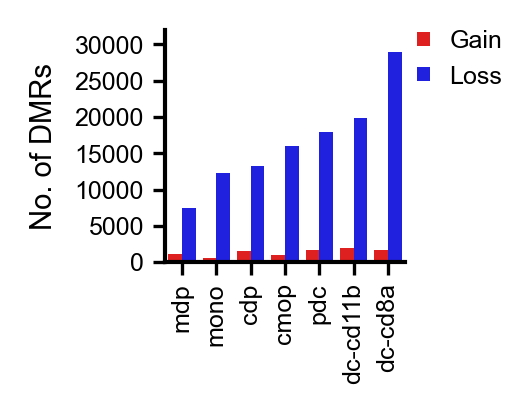

In [163]:
fig, ax = plt.subplots(
    1, 1, dpi=300, constrained_layout=True, figsize=(4 / 2.54, 3 / 2.54)
)
sns.barplot(
    x="Population",
    y="No. of DMRs",
    hue="Direction",
    palette={"Loss": "Blue", "Gain": "Red"},
    data=pw_counts_plot_df,
    order=gain_loss_counts.index,
)
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks(np.arange(0, 40_000, 5_000))
ax.set_ylim(0, 32_000)
ax.set(xlabel="")
fig.savefig(results_dir + "gain-loss-pw-counts-barplot.pdf")
link_fn(results_dir + "gain-loss-pw-counts-barplot.pdf")

# Test significance of population meth differences

In [ ]:
q1_median_q3_rep_wide, q1_median_q3_rep_long = lib.get_meth_stats_arrays(meth_stats_rep)